In this notebook, we will create features using k-means clustering

In [25]:
#Set up notebooks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

#matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes',
      labelweight='bold',
      labelsize='large',
      titleweight='bold',
      titlesize=14,
      titlepad=10)

#score functions
def score_dataset(X, y, model=XGBRegressor()):
    #label encoding
    for colname in X.select_dtypes(['category', 'object']):
        X[colname], _ = X[colname].factorize()
        
    #Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_log_error')
        
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score
    
#load dataset Ames
df = pd.read_csv('./data/house-prices-advanced-regression-techniques/ames.csv')

The k-means algorithm is sensitive to scale. This means we need to be thoughtful about how and whether rescale our features since we might get very different results depending on our choices. As a rule of thumb, if the features are already directly comparable (like a test result at different times), then we would not want rescale. On the other hand, faetures that arenot on comparable scales(like height and weight) will ussually benefit from rescaling. Sometimes, the choice won't be clear though. In that case, we should try to use common sense, remembering that faetures with larger values will be weighted more heavily.

In [6]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF',

#### 1. Scaling Features

Consider the following sets of features. For each, decide whether:
* they definitely should be rescaled,
* they definitely should not be rescaled or either might be reasonable

Example of rescaling features or should not:
1. Latitude and longitude of cities in California
 * This is natural distances described by Latitude and Longitude, we will skip off scaling
2. Lot Area and Living Area of houses in Ames
 * Lot Area and Living Area are measured per square foot, the value on Lot Area are too much higher than in Living Area, we need to rescale these two features, so non of them weighted more than the others in the clustering, both effect on SalePrice. 
3. Number of Doors and Horsepower of a 1989 model car
 * their values can not be comparable, one is 2 or 4 doors, the another is hundreds usually, so we will rescale them
 
For Scaling features, it will usually depend on some domain knowledge about data and what we are trying to predict.
 - Comparing different rescaling schemes through cross-validation can also be helpful.
 - checking out the preprocessing module in scikit-learn for some of the rescaling methods

#### 2. Create a Feture of Cluster labels
creating a k-means clustering with the following parameters:
* features: LotArea, TotalBsmtSF, FirstFlrSF, SecondFlrSF, GrLivArea
* number of clusters 10
* interations 10

NOTE: for choosing k params in k-means cluster, we could use Methods such as, Elbow method or Silhouette Method

In [10]:
df[['LotArea', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea']]

,LotArea,TotalBsmtSF,FirstFlrSF,SecondFlrSF,GrLivArea
0,31770.0,1080.0,1656.0,0.0,1656.0
1,11622.0,882.0,896.0,0.0,896.0
2,14267.0,1329.0,1329.0,0.0,1329.0
3,11160.0,2110.0,2110.0,0.0,2110.0
4,13830.0,928.0,928.0,701.0,1629.0
...,...,...,...,...,...
2925,7937.0,1003.0,1003.0,0.0,1003.0
2926,8885.0,864.0,902.0,0.0,902.0
2927,10441.0,912.0,970.0,0.0,970.0
2928,10010.0,1389.0,1389.0,0.0,1389.0


In [28]:
X = df.copy()
y = X.pop("SalePrice")


# Define a list of the features to be used for the clustering
features = ['LotArea', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea']


# Standardize
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)


# Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
X["Cluster"] = kmeans.fit_predict(X_scaled)
X['Cluster'] = X['Cluster'].astype('category')


# Checking
X[features+['Cluster']].head(5)

,LotArea,TotalBsmtSF,FirstFlrSF,SecondFlrSF,GrLivArea,Cluster
0,31770.0,1080.0,1656.0,0.0,1656.0,9
1,11622.0,882.0,896.0,0.0,896.0,5
2,14267.0,1329.0,1329.0,0.0,1329.0,0
3,11160.0,2110.0,2110.0,0.0,2110.0,6
4,13830.0,928.0,928.0,701.0,1629.0,3


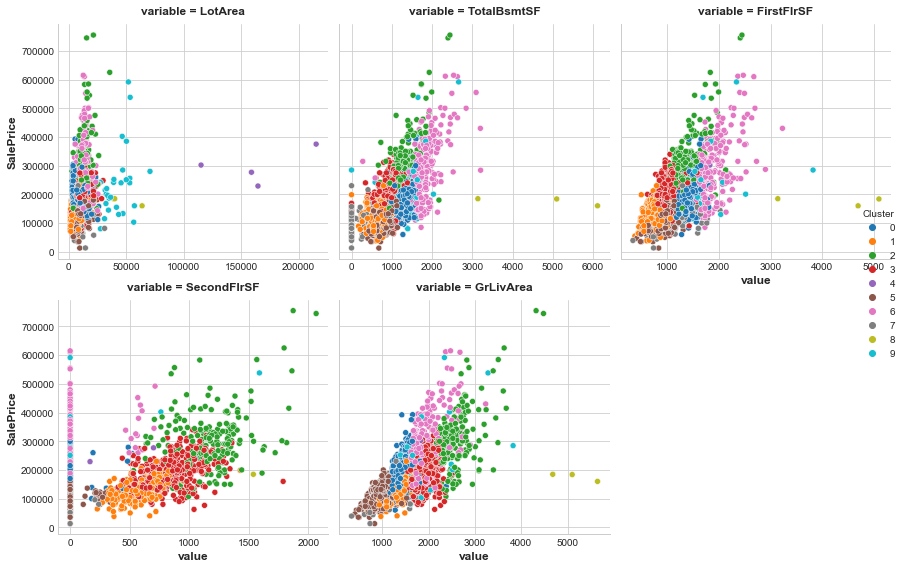

In [21]:
#plotting clustering
Xy = X.copy()
Xy['Cluster'] = Xy.Cluster.astype('category')
Xy['SalePrice'] = y
sns.relplot(x='value', y='SalePrice', hue='Cluster', col='variable', 
           height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
            data=Xy.melt(value_vars=features, id_vars=['SalePrice', 'Cluster'],),);

In [26]:
#get score with new features
score_dataset(X, y)

0.14314322905088217

#### 3. Clustering-distance features
The k-means algorithm offers an laternative way of creating features. Instead of labeling each feature with the nearest cluster centroid, it can measure the distance from a point to all the centroids and return those distances as features.

In [31]:
# Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)

X_cd = kmeans.fit_transform(X_scaled)

#label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f'Centroid_{i}' for i in range(X_cd.shape[1])])
X = X.join(X_cd)


# Checking
X[X_cd.columns].head(5)

,Centroid_0,Centroid_1,Centroid_2,Centroid_3,Centroid_4,Centroid_5,Centroid_6,Centroid_7,Centroid_8,Centroid_9
0,2.977514,4.324979,4.172115,3.780258,16.792665,3.696276,3.032162,3.912313,13.097627,1.677604
1,1.969544,1.879362,4.654799,2.754284,19.594509,0.461371,3.852233,1.941728,15.785445,5.026636
2,0.644657,2.716520,3.743687,2.616186,19.030448,1.650239,2.135609,2.888012,14.058973,3.965749
3,2.868083,5.244512,3.885630,4.432911,19.392116,4.576079,0.995900,5.513141,11.373003,4.586658
4,2.333623,1.313746,2.689990,0.738670,19.225117,2.175157,3.569021,2.691082,14.749591,4.469214


In [32]:
#scoring with new features above
score_dataset(X, y)

0.1408559614587017